# Sommaire

* [Introduction](#introduction)
* [I) Import](#i)
* [II) Préparation des données](#ii)
* [III) Choix des modèles et des métriques de notation](#iii)
* [IV) Validation croisée](#iv)
* [V) Choix du modèle et feature importance](#v)
* [VI) ENERGYSTARScore](#vi)
* [Conclusion](#conclusion)

# Introduction <a class="anchor" id="introduction"></a>
Dans ce notebook, on enchaîne avec les prédicitions. On va commencer par SiteEnergyUse(kBtu). L'objectif étant d'effectuer des prédictions sur des bâtiments où les relevés n'ont pas été effectués, nous allons les retirer du jeu de données.

D'abord on va développer un modèle sans ENERGYSTARScore. Mais on se servira de cette variable à la fin pour évaluer son impact sur le modèle retenu.

# I) Import <a class="anchor" id="i"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_final = pd.read_pickle('data_final.pkl')
data_final

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,ZipCode,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,...,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,98101,7,DOWNTOWN,89,1,12,...,NC,60,81.699997,182.500000,7.226362e+06,2003882.00,3.946027e+06,1.276453e+06,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,98101,7,DOWNTOWN,20,1,11,...,Restaurant,61,94.800003,176.100006,8.387933e+06,0.00,3.242851e+06,5.145082e+06,295.86,2.86
2,3,NonResidential,Hotel,5673-The Westin Seattle,98101,7,DOWNTOWN,47,1,41,...,NC,43,96.000000,241.899994,7.258702e+07,21566554.00,4.952666e+07,1.493800e+06,2089.28,2.19
3,5,NonResidential,Hotel,HOTEL MAX,98101,7,DOWNTOWN,90,1,10,...,NC,56,110.800003,216.199997,6.794584e+06,2214446.25,2.768924e+06,1.811213e+06,286.43,4.67
4,8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),98121,7,DOWNTOWN,36,1,18,...,Swimming Pool,75,114.800003,211.399994,1.417261e+07,0.00,5.368607e+06,8.803998e+06,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,50221,Nonresidential COS,Other,High Point Community Center,98126,1,DELRIDGE,34,1,1,...,NC,<NA>,51.000000,126.000000,9.320821e+05,0.00,6.323620e+05,2.997200e+05,20.33,1.11
1542,50223,Nonresidential COS,Other,International district/Chinatown CC,98104,2,DOWNTOWN,12,1,1,...,NC,<NA>,59.400002,114.199997,9.502762e+05,0.00,3.965461e+05,5.537300e+05,32.17,2.01
1543,50224,Nonresidential COS,Other,Queen Anne Pool,98119,7,MAGNOLIA / QUEEN ANNE,42,1,1,...,Swimming Pool,<NA>,438.200012,744.799988,5.765898e+06,0.00,1.792159e+06,3.973739e+06,223.54,16.99
1544,50225,Nonresidential COS,Mixed Use Property,South Park Community Center,98108,1,GREATER DUWAMISH,27,1,1,...,Other,<NA>,51.000000,105.300003,7.194712e+05,0.00,3.488702e+05,3.706010e+05,22.11,1.57


In [2]:
#Pour se débarasser de la notation scientifique de certaines colonnes
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# II) Préparation des données <a class="anchor" id="ii"></a>

In [3]:
#On commence par retirer ENERGYSTARScore, on développe le modèle sans mais on s'en servira plus tard
ess = data_final[['ENERGYSTARScore']]

#On m'informe qu'un relevé de référence sera fait pour chaque nouveau bâtiment
#Aussi, des informations telles que la nature et proportion des sources d'énergie utilisées sont exploitables
#On additionne SteamUse, Electricity et NaturalGas (par bonheur elles partagent la même unité de mesure)
data_final['TotalEnergy'] = data_final['SteamUse(kBtu)'] + data_final['Electricity(kBtu)'] + data_final['NaturalGas(kBtu)']

#Puis on divise
data_final['SteamUse%'] = data_final['SteamUse(kBtu)'] / data_final['TotalEnergy'] * 100
data_final['Electricity%'] = data_final['Electricity(kBtu)'] / data_final['TotalEnergy'] * 100
data_final['NaturalGas%'] = data_final['NaturalGas(kBtu)'] / data_final['TotalEnergy'] * 100
data_final

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,ZipCode,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,...,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,TotalEnergy,SteamUse%,Electricity%,NaturalGas%
0,1,NonResidential,Hotel,Mayflower park hotel,98101,7,DOWNTOWN,89,1,12,...,7226362.500,2003882.000,3946027.000,1276453.000,249.980,2.830,7226362.000,27.730,54.606,17.664
1,2,NonResidential,Hotel,Paramount Hotel,98101,7,DOWNTOWN,20,1,11,...,8387933.000,0.000,3242851.000,5145082.000,295.860,2.860,8387933.000,0.000,38.661,61.339
2,3,NonResidential,Hotel,5673-The Westin Seattle,98101,7,DOWNTOWN,47,1,41,...,72587024.000,21566554.000,49526664.000,1493800.000,2089.280,2.190,72587018.000,29.711,68.231,2.058
3,5,NonResidential,Hotel,HOTEL MAX,98101,7,DOWNTOWN,90,1,10,...,6794584.000,2214446.250,2768924.000,1811213.000,286.430,4.670,6794583.250,32.591,40.752,26.657
4,8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),98121,7,DOWNTOWN,36,1,18,...,14172606.000,0.000,5368607.000,8803998.000,505.010,2.880,14172605.000,0.000,37.880,62.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,50221,Nonresidential COS,Other,High Point Community Center,98126,1,DELRIDGE,34,1,1,...,932082.125,0.000,632362.007,299719.995,20.330,1.110,932082.002,0.000,67.844,32.156
1542,50223,Nonresidential COS,Other,International district/Chinatown CC,98104,2,DOWNTOWN,12,1,1,...,950276.188,0.000,396546.052,553729.980,32.170,2.010,950276.032,0.000,41.730,58.270
1543,50224,Nonresidential COS,Other,Queen Anne Pool,98119,7,MAGNOLIA / QUEEN ANNE,42,1,1,...,5765898.000,0.000,1792158.758,3973739.063,223.540,16.990,5765897.821,0.000,31.082,68.918
1544,50225,Nonresidential COS,Mixed Use Property,South Park Community Center,98108,1,GREATER DUWAMISH,27,1,1,...,719471.188,0.000,348870.176,370601.001,22.110,1.570,719471.177,0.000,48.490,51.510


In [4]:
#Par précaution
data_final.loc[data_final['TotalEnergy'] == 0]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,ZipCode,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,...,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,TotalEnergy,SteamUse%,Electricity%,NaturalGas%
454,700,NonResidential,Supermarket / Grocery Store,IUC- Whole Foods Interbay,98119,7,MAGNOLIA / QUEEN ANNE,8,1,1,...,12525174.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN


In [5]:
#On a bien fait de vérifier, cette résidence n'a pratiquement que des 0 en dehors de la cible, cela me semble incohérent donc je la supprime
data_final = data_final.drop(454).reset_index(drop=True)

In [6]:
#On peut enfin retirer les relevés, ainsi qu'OSEBuildingID et PropertyName qui servaient pour l'identification, mais ne seront pas utiles au modèle
df = data_final.drop(['OSEBuildingID', 'PropertyName', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
                      'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'TotalEnergy'], axis=1)
df

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SiteEnergyUse(kBtu),SteamUse%,Electricity%,NaturalGas%
0,NonResidential,Hotel,98101,7,DOWNTOWN,89,1,12,88434,0,88434,Hotel,NC,NC,7226362.500,27.730,54.606,17.664
1,NonResidential,Hotel,98101,7,DOWNTOWN,20,1,11,103566,15064,88502,Hotel,Parking,Restaurant,8387933.000,0.000,38.661,61.339
2,NonResidential,Hotel,98101,7,DOWNTOWN,47,1,41,956110,196718,759392,Hotel,NC,NC,72587024.000,29.711,68.231,2.058
3,NonResidential,Hotel,98101,7,DOWNTOWN,90,1,10,61320,0,61320,Hotel,NC,NC,6794584.000,32.591,40.752,26.657
4,NonResidential,Hotel,98121,7,DOWNTOWN,36,1,18,175580,62000,113580,Hotel,Parking,Swimming Pool,14172606.000,0.000,37.880,62.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,Nonresidential COS,Other,98126,1,DELRIDGE,34,1,1,18261,0,18261,Other,NC,NC,932082.125,0.000,67.844,32.156
1541,Nonresidential COS,Other,98104,2,DOWNTOWN,12,1,1,16000,0,16000,Other,NC,NC,950276.188,0.000,41.730,58.270
1542,Nonresidential COS,Other,98119,7,MAGNOLIA / QUEEN ANNE,42,1,1,13157,0,13157,Other,Fitness Center/Health Club/Gym,Swimming Pool,5765898.000,0.000,31.082,68.918
1543,Nonresidential COS,Mixed Use Property,98108,1,GREATER DUWAMISH,27,1,1,14101,0,14101,Other,Fitness Center/Health Club/Gym,Other,719471.188,0.000,48.490,51.510


In [7]:
#On retire les lignes restantes où la cible vaut 0
df = df[df['SiteEnergyUse(kBtu)'] != 0].reset_index(drop=True)
df

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SiteEnergyUse(kBtu),SteamUse%,Electricity%,NaturalGas%
0,NonResidential,Hotel,98101,7,DOWNTOWN,89,1,12,88434,0,88434,Hotel,NC,NC,7226362.500,27.730,54.606,17.664
1,NonResidential,Hotel,98101,7,DOWNTOWN,20,1,11,103566,15064,88502,Hotel,Parking,Restaurant,8387933.000,0.000,38.661,61.339
2,NonResidential,Hotel,98101,7,DOWNTOWN,47,1,41,956110,196718,759392,Hotel,NC,NC,72587024.000,29.711,68.231,2.058
3,NonResidential,Hotel,98101,7,DOWNTOWN,90,1,10,61320,0,61320,Hotel,NC,NC,6794584.000,32.591,40.752,26.657
4,NonResidential,Hotel,98121,7,DOWNTOWN,36,1,18,175580,62000,113580,Hotel,Parking,Swimming Pool,14172606.000,0.000,37.880,62.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,Nonresidential COS,Other,98126,1,DELRIDGE,34,1,1,18261,0,18261,Other,NC,NC,932082.125,0.000,67.844,32.156
1541,Nonresidential COS,Other,98104,2,DOWNTOWN,12,1,1,16000,0,16000,Other,NC,NC,950276.188,0.000,41.730,58.270
1542,Nonresidential COS,Other,98119,7,MAGNOLIA / QUEEN ANNE,42,1,1,13157,0,13157,Other,Fitness Center/Health Club/Gym,Swimming Pool,5765898.000,0.000,31.082,68.918
1543,Nonresidential COS,Mixed Use Property,98108,1,GREATER DUWAMISH,27,1,1,14101,0,14101,Other,Fitness Center/Health Club/Gym,Other,719471.188,0.000,48.490,51.510


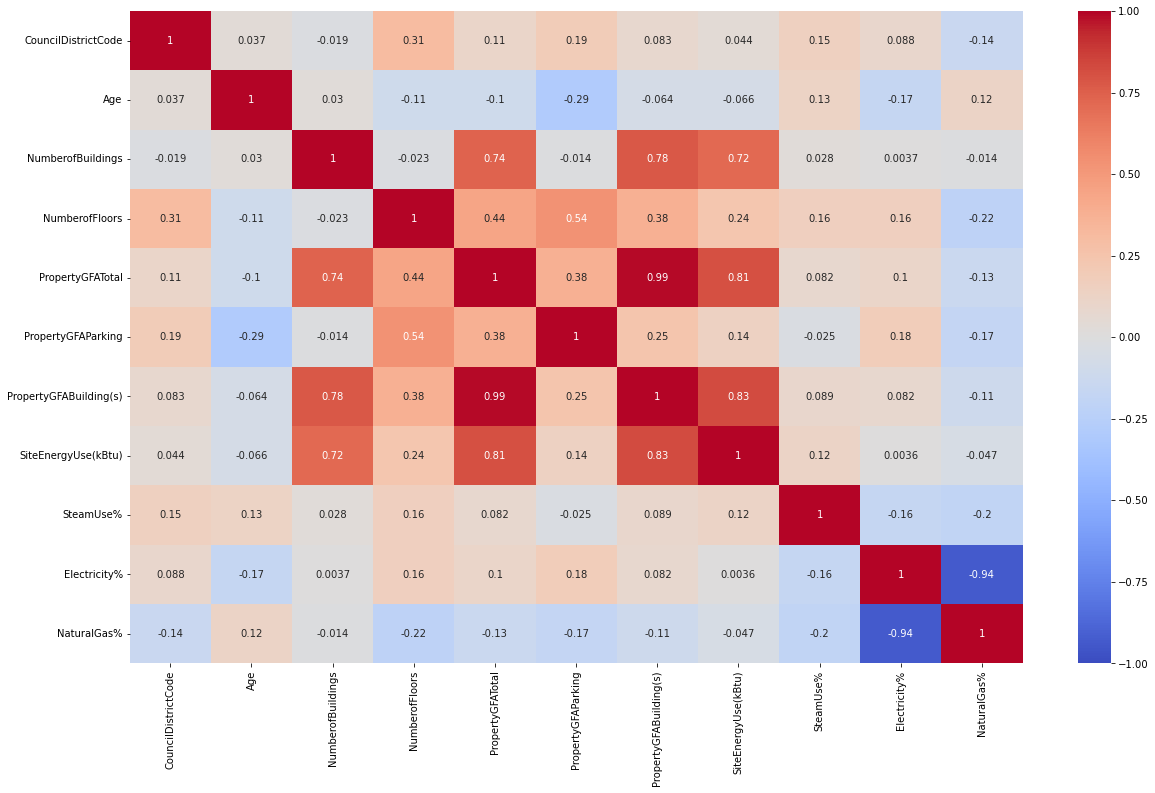

In [8]:
#On n'en a pas finalement, sans doute parties avec les résidences non conformes
#On s'intéresse maintenant à la colinéarité des variables
corr_matrix = df.select_dtypes(include=['int', 'float']).corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1)
plt.show()

In [9]:
#On a des scores très élevés entre PropertyGFATotal et PropertyGFABuilding(s)
#Pour y remédier, je choisis de diviser PropertyGFABuilding(s) par le nombre d'étages
df['PropertyGFABuilding(s)'] = df['PropertyGFABuilding(s)'] / df['NumberofFloors']
df = df.rename(columns={'PropertyGFABuilding(s)': 'BuildingGFAperFloor'})
df

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingGFAperFloor,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SiteEnergyUse(kBtu),SteamUse%,Electricity%,NaturalGas%
0,NonResidential,Hotel,98101,7,DOWNTOWN,89,1,12,88434,0,7369.500,Hotel,NC,NC,7226362.500,27.730,54.606,17.664
1,NonResidential,Hotel,98101,7,DOWNTOWN,20,1,11,103566,15064,8045.636,Hotel,Parking,Restaurant,8387933.000,0.000,38.661,61.339
2,NonResidential,Hotel,98101,7,DOWNTOWN,47,1,41,956110,196718,18521.756,Hotel,NC,NC,72587024.000,29.711,68.231,2.058
3,NonResidential,Hotel,98101,7,DOWNTOWN,90,1,10,61320,0,6132.000,Hotel,NC,NC,6794584.000,32.591,40.752,26.657
4,NonResidential,Hotel,98121,7,DOWNTOWN,36,1,18,175580,62000,6310.000,Hotel,Parking,Swimming Pool,14172606.000,0.000,37.880,62.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,Nonresidential COS,Other,98126,1,DELRIDGE,34,1,1,18261,0,18261.000,Other,NC,NC,932082.125,0.000,67.844,32.156
1541,Nonresidential COS,Other,98104,2,DOWNTOWN,12,1,1,16000,0,16000.000,Other,NC,NC,950276.188,0.000,41.730,58.270
1542,Nonresidential COS,Other,98119,7,MAGNOLIA / QUEEN ANNE,42,1,1,13157,0,13157.000,Other,Fitness Center/Health Club/Gym,Swimming Pool,5765898.000,0.000,31.082,68.918
1543,Nonresidential COS,Mixed Use Property,98108,1,GREATER DUWAMISH,27,1,1,14101,0,14101.000,Other,Fitness Center/Health Club/Gym,Other,719471.188,0.000,48.490,51.510


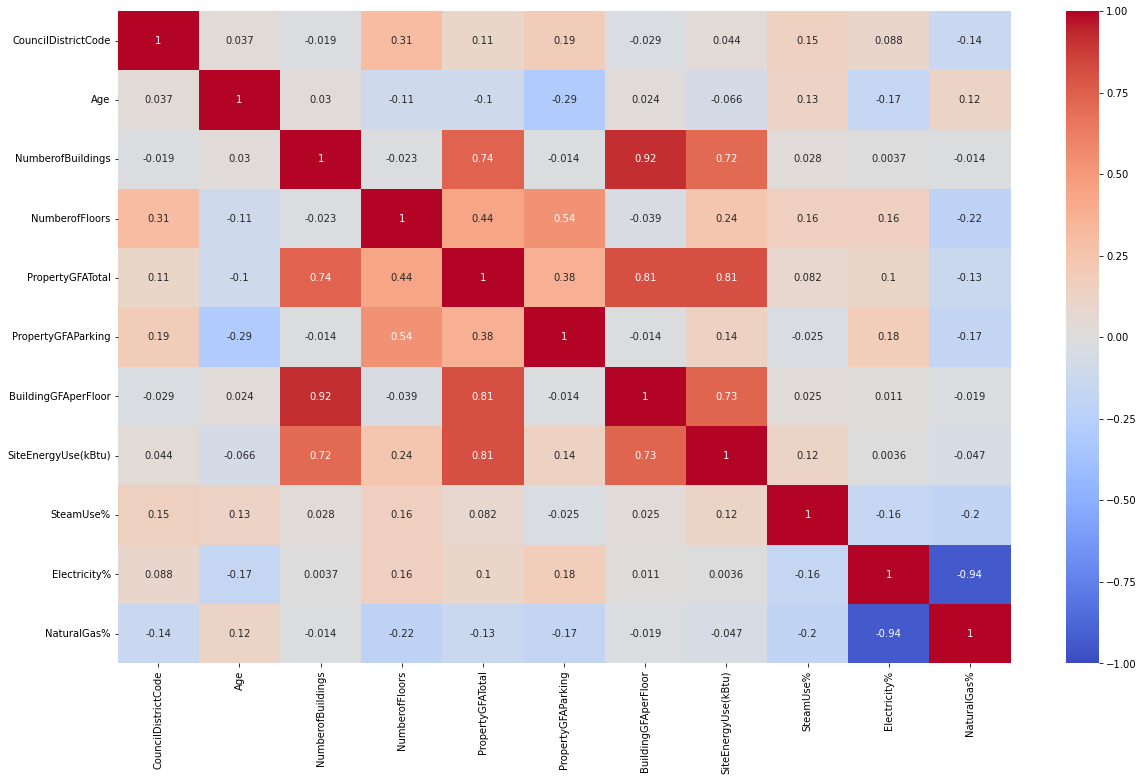

In [10]:
#On vérifie
corr_matrix = df.select_dtypes(include=['int', 'float']).corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1)
plt.show()

In [11]:
#Voilà qui est mieux, malgré quelques paires de variables fortement liées telles NumberofBuildings et BuildingGFAperFloor
#On laisse tel quel pour l'instant, on reviendra sur cette décission si cela pose problème au niveau des modèles
#On va désormais séparer les variables qualitatives et quantitatives
#On transforme CouncilDistrictCode en type object, ce sera plus simple pour les encoders
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].astype(object)

var_quali = df.select_dtypes(include=['object']).columns
var_quali

Index(['BuildingType', 'PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode',
       'Neighborhood', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'],
      dtype='object')

In [12]:
var_quanti = df.select_dtypes(include=['int','float']).columns
var_quanti = var_quanti.delete([-4]) #On retire la cible SiteEnergyUse(kBtu)
var_quanti

Index(['Age', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'BuildingGFAperFloor', 'SteamUse%',
       'Electricity%', 'NaturalGas%'],
      dtype='object')

In [13]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [14]:
#On va tester plusieurs encoders pour nos variables qualitatives : OneHot, Binary et Target
#Ce sera StandardScaler pour les variables quantitatives dans tous les cas
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import BinaryEncoder, TargetEncoder
from sklearn.compose import make_column_transformer

preprocessor_oh = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False), var_quali),
                                          (StandardScaler(), var_quanti))

preprocessor_b = make_column_transformer((BinaryEncoder(), var_quali), 
                                         (StandardScaler(), var_quanti))

preprocessor_t = make_column_transformer((TargetEncoder(), var_quali),
                                         (StandardScaler(), var_quanti))

In [15]:
#On définit X et y
X = df.drop('SiteEnergyUse(kBtu)', axis=1)
y = df['SiteEnergyUse(kBtu)']

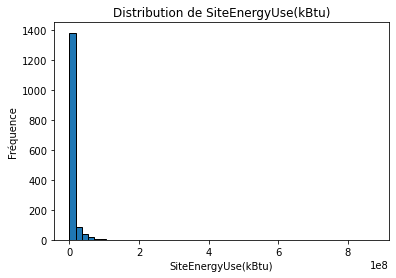

In [16]:
#On s'intéresse à la distribution de y
plt.hist(y, bins=50, edgecolor='black')
plt.title('Distribution de SiteEnergyUse(kBtu)')
plt.xlabel('SiteEnergyUse(kBtu)')
plt.ylabel('Fréquence')
plt.show()

In [17]:
#On constate qu'elle est asymétrique, on tente un passage au log
y = np.log1p(y)

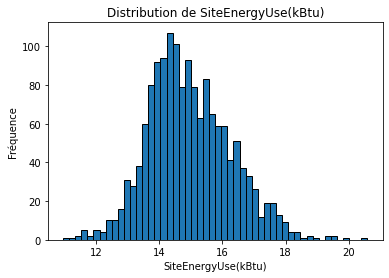

In [18]:
#Même démarche
plt.hist(y, bins=50, edgecolor='black')
plt.title('Distribution de SiteEnergyUse(kBtu)')
plt.xlabel('SiteEnergyUse(kBtu)')
plt.ylabel('Fréquence')
plt.show()

In [19]:
#Le passage au log a permis de réduire les valeurs extrêmes ainsi que d'aboutir à une distribution plus proche de la distribution normale
#On sépare jeu de test et jeu d'entraînement
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
#Transformation des X
X_train_oh = preprocessor_oh.fit_transform(X_train)
X_test_oh = preprocessor_oh.transform(X_test)

X_train_b = preprocessor_b.fit_transform(X_train)
X_test_b = preprocessor_b.transform(X_test)

X_train_t = preprocessor_t.fit_transform(X_train, y_train)
X_test_t = preprocessor_t.transform(X_test)

#Transformation des y
scalery = StandardScaler()
y_train_scaled = scalery.fit_transform(y_train.values.reshape(-1, 1)).flatten() #Pour un résultat unidimensionnel
y_test_scaled = scalery.transform(y_test.values.reshape(-1, 1)).flatten() #Idem

In [20]:
#On voit que les dimensions ne sont pas les mêmes d'un encodage à l'autre
print(X_train_oh.shape)
print(X_train_b.shape)
print(X_train_t.shape)

(1236, 119)
(1236, 42)
(1236, 17)


In [21]:
#Par curiosité
noms_features = np.concatenate((var_quali, var_quanti))
pd.DataFrame(X_train_t, columns=noms_features)

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingGFAperFloor,SteamUse%,Electricity%,NaturalGas%
0,14.933,15.806,15.010,14.589,14.735,15.717,15.709,15.118,-0.249,-0.073,-0.499,0.055,0.478,0.244,-0.237,0.285,-0.202
1,14.933,14.527,14.493,14.515,14.435,15.202,15.296,14.839,0.363,-0.073,-0.499,-0.093,-0.319,0.197,-0.237,-0.294,0.372
2,14.933,14.025,14.493,14.515,14.435,14.046,14.685,14.839,1.893,-0.073,-0.351,-0.219,-0.319,-0.054,-0.237,-1.818,1.881
3,14.933,15.139,15.028,15.139,15.121,15.491,15.061,14.839,-1.137,-0.073,-0.351,-0.117,1.154,-0.113,-0.237,-1.416,1.483
4,14.933,14.025,14.230,14.804,14.435,14.046,14.685,14.839,-0.341,-0.073,-0.499,-0.268,-0.319,-0.017,-0.237,-1.983,2.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,14.933,14.146,14.493,14.515,14.435,14.135,14.634,14.839,0.240,-0.073,-0.499,-0.268,-0.319,-0.017,-0.237,-0.035,0.115
1232,14.933,15.139,15.435,15.407,14.837,15.085,15.709,14.839,-0.556,-0.073,-0.204,-0.285,-0.319,-0.112,-0.237,1.146,-1.055
1233,14.933,15.410,14.843,15.407,14.837,15.530,14.634,15.118,-0.005,-0.073,-0.351,-0.273,-0.319,-0.086,-0.237,-1.181,1.250
1234,14.933,14.527,15.256,15.407,15.546,15.202,15.709,14.839,-0.709,-0.073,0.238,-0.155,-0.319,-0.105,-0.237,1.146,-1.055


In [22]:
#Dernière manipulation avant la suite, il faut centrer et réduire les variables qualitatives qui ont subit l'encodage Target (les 8 premières colonnes donc)
scalerx = StandardScaler()
X_train_t[:, :8] = scalerx.fit_transform(X_train_t[:, :8])
X_test_t[:, :8] = scalerx.transform(X_test_t[:, :8])

In [23]:
#On vérifie
pd.DataFrame(X_train_t, columns=noms_features)

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingGFAperFloor,SteamUse%,Electricity%,NaturalGas%
0,-0.193,1.171,0.057,-1.053,-0.594,1.411,1.780,0.651,-0.249,-0.073,-0.499,0.055,0.478,0.244,-0.237,0.285,-0.202
1,-0.193,-0.563,-1.032,-1.257,-1.339,0.482,0.794,-0.423,0.363,-0.073,-0.499,-0.093,-0.319,0.197,-0.237,-0.294,0.372
2,-0.193,-1.244,-1.032,-1.257,-1.339,-1.606,-0.668,-0.423,1.893,-0.073,-0.351,-0.219,-0.319,-0.054,-0.237,-1.818,1.881
3,-0.193,0.266,0.096,0.472,0.365,1.003,0.232,-0.423,-1.137,-0.073,-0.351,-0.117,1.154,-0.113,-0.237,-1.416,1.483
4,-0.193,-1.244,-1.585,-0.457,-1.339,-1.606,-0.668,-0.423,-0.341,-0.073,-0.499,-0.268,-0.319,-0.017,-0.237,-1.983,2.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,-0.193,-1.080,-1.032,-1.257,-1.339,-1.445,-0.789,-0.423,0.240,-0.073,-0.499,-0.268,-0.319,-0.017,-0.237,-0.035,0.115
1232,-0.193,0.266,0.951,1.214,-0.340,0.269,1.780,-0.423,-0.556,-0.073,-0.204,-0.285,-0.319,-0.112,-0.237,1.146,-1.055
1233,-0.193,0.633,-0.295,1.214,-0.340,1.074,-0.789,0.651,-0.005,-0.073,-0.351,-0.273,-0.319,-0.086,-0.237,-1.181,1.250
1234,-0.193,-0.563,0.575,1.214,1.423,0.482,1.780,-0.423,-0.709,-0.073,0.238,-0.155,-0.319,-0.105,-0.237,1.146,-1.055


# III) Choix des modèles et des métriques de notation <a class="anchor" id="iii"></a>

In [24]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [25]:
#Les modèles qu'on va tester
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
    
modèles = {'DummyRegressor' : DummyRegressor(strategy="median"), #Moins sensible aux outliers que "mean"
           'Ridge' : Ridge(),
           'Lasso' : Lasso(),
           'ElasticNet' : ElasticNet(),
           'DecisionTree' : DecisionTreeRegressor(random_state=42),
           'SVR' : SVR(),
           'KernelRidge' : KernelRidge(),
           'RandomForestRegressor' : RandomForestRegressor(random_state=42),
           'XGBRegressor' : XGBRegressor()}

In [26]:
#On commence par tester ces métriques pour chaque modèle et sur chaque encoder sans toucher aux hyperparamètres
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Pour enregistrer les résultats, on commence par l'encodage OneHot
résultats_oh = []

#Une boucle par modèle
for nom_modèle, modèle in modèles.items():
        
    #On fit
    modèle.fit(X_train_oh, y_train_scaled)
    y_pred = modèle.predict(X_test_oh)
    
    #Evaluation des performances
    print(f"Performance {nom_modèle} :")
    MAE = mean_absolute_error(y_test_scaled, y_pred)
    MSE = mean_squared_error(y_test_scaled, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test_scaled, y_pred, multioutput="variance_weighted")
    print("MAE =", MAE)        
    print("MSE =", MSE)
    print("RMSE =", RMSE)
    print("R² =", R2)
    print("\n")

    #On ajoute les résultats à la liste
    résultats_oh.append([nom_modèle, MAE, MSE, RMSE, R2])

Performance DummyRegressor :
MAE = 0.774170272054961
MSE = 0.9967549805013247
RMSE = 0.9983761718417186
R² = -0.004030602545572748


Performance Ridge :
MAE = 0.4848608603745417
MSE = 0.4167135404757415
RMSE = 0.6455335316431994
R² = 0.5802447388601721


Performance Lasso :
MAE = 0.7820990218083103
MSE = 0.9949519737835962
RMSE = 0.9974727935054651
R² = -0.0022144351256876416


Performance ElasticNet :
MAE = 0.7820990218083103
MSE = 0.9949519737835962
RMSE = 0.9974727935054651
R² = -0.0022144351256876416


Performance DecisionTree :
MAE = 0.5445458225743638
MSE = 0.5367869154670838
RMSE = 0.732657433912387
R² = 0.45929491126903954


Performance SVR :
MAE = 0.387275771122812
MSE = 0.2771676141066061
RMSE = 0.5264671063861504
R² = 0.7208092539877661


Performance KernelRidge :
MAE = 0.485056502735817
MSE = 0.41682005311082776
RMSE = 0.6456160260641209
R² = 0.5801374487565093


Performance RandomForestRegressor :
MAE = 0.39093536470969864
MSE = 0.28065423123897953
RMSE = 0.529768091941162

In [27]:
#Pour y voir plus clair
résultats_oh = pd.DataFrame(résultats_oh, columns=['Modèle', 'MAE', 'MSE', 'RMSE', 'R²'])
résultats_oh

,Modèle,MAE,MSE,RMSE,R²
0,DummyRegressor,0.774,0.997,0.998,-0.004
1,Ridge,0.485,0.417,0.646,0.580
2,Lasso,0.782,0.995,0.997,-0.002
3,ElasticNet,0.782,0.995,0.997,-0.002
4,DecisionTree,0.545,0.537,0.733,0.459
5,SVR,0.387,0.277,0.526,0.721
6,KernelRidge,0.485,0.417,0.646,0.580
7,RandomForestRegressor,0.391,0.281,0.530,0.717
8,XGBRegressor,0.399,0.314,0.560,0.684


In [28]:
#Même chose avec l'encodage binaire
résultats_b = []

#Une boucle par modèle
for nom_modèle, modèle in modèles.items():
        
    #On fit
    modèle.fit(X_train_b, y_train_scaled)
    y_pred = modèle.predict(X_test_b)
    
    #Evaluation des performances
    print(f"Performance {nom_modèle} :")
    MAE = mean_absolute_error(y_test_scaled, y_pred)
    MSE = mean_squared_error(y_test_scaled, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test_scaled, y_pred, multioutput="variance_weighted")
    print("MAE =", MAE)        
    print("MSE =", MSE)
    print("RMSE =", RMSE)
    print("R² =", R2)
    print("\n")

    #On ajoute les résultats à la liste
    résultats_b.append([nom_modèle, MAE, MSE, RMSE, R2])

Performance DummyRegressor :
MAE = 0.774170272054961
MSE = 0.9967549805013247
RMSE = 0.9983761718417186
R² = -0.004030602545572748


Performance Ridge :
MAE = 0.5492550315724424
MSE = 0.5162020803523624
RMSE = 0.7184720456304214
R² = 0.4800300014445007


Performance Lasso :
MAE = 0.7820990218083103
MSE = 0.9949519737835962
RMSE = 0.9974727935054651
R² = -0.0022144351256876416


Performance ElasticNet :
MAE = 0.7820990218083103
MSE = 0.9949519737835962
RMSE = 0.9974727935054651
R² = -0.0022144351256876416


Performance DecisionTree :
MAE = 0.5770871315543542
MSE = 0.5858516207610325
RMSE = 0.7654094464801388
R² = 0.4098720675575114


Performance SVR :
MAE = 0.4238312266937571
MSE = 0.322507634285524
RMSE = 0.5678975561538577
R² = 0.6751382830167745


Performance KernelRidge :
MAE = 0.5464600267806601
MSE = 0.5118100574500979
RMSE = 0.7154090140962007
R² = 0.48445408307661525


Performance RandomForestRegressor :
MAE = 0.3974535663910378
MSE = 0.29775183808618294
RMSE = 0.545666416491049

In [29]:
#Pour y voir plus clair
résultats_b = pd.DataFrame(résultats_b, columns=['Modèle', 'MAE', 'MSE', 'RMSE', 'R²'])
résultats_b

,Modèle,MAE,MSE,RMSE,R²
0,DummyRegressor,0.774,0.997,0.998,-0.004
1,Ridge,0.549,0.516,0.718,0.480
2,Lasso,0.782,0.995,0.997,-0.002
3,ElasticNet,0.782,0.995,0.997,-0.002
4,DecisionTree,0.577,0.586,0.765,0.410
5,SVR,0.424,0.323,0.568,0.675
6,KernelRidge,0.546,0.512,0.715,0.484
7,RandomForestRegressor,0.397,0.298,0.546,0.700
8,XGBRegressor,0.414,0.317,0.563,0.680


In [30]:
#Et enfin, l'encodage Target
résultats_t = []

#Une boucle par modèle
for nom_modèle, modèle in modèles.items():
        
    #On fit
    modèle.fit(X_train_t, y_train_scaled)
    y_pred = modèle.predict(X_test_t)
    
    #Evaluation des performances
    print(f"Performance {nom_modèle} :")
    MAE = mean_absolute_error(y_test_scaled, y_pred)
    MSE = mean_squared_error(y_test_scaled, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test_scaled, y_pred, multioutput="variance_weighted")
    print("MAE =", MAE)        
    print("MSE =", MSE)
    print("RMSE =", RMSE)
    print("R² =", R2)
    print("\n")

    #On ajoute les résultats à la liste
    résultats_t.append([nom_modèle, MAE, MSE, RMSE, R2])

Performance DummyRegressor :
MAE = 0.774170272054961
MSE = 0.9967549805013247
RMSE = 0.9983761718417186
R² = -0.004030602545572748


Performance Ridge :
MAE = 0.49269540110352894
MSE = 0.4300838667798751
RMSE = 0.6558077971325708
R² = 0.5667768184203681


Performance Lasso :
MAE = 0.7820990218083103
MSE = 0.9949519737835962
RMSE = 0.9974727935054651
R² = -0.0022144351256876416


Performance ElasticNet :
MAE = 0.7389418908420288
MSE = 0.9099246169738631
RMSE = 0.953899689157022
R² = 0.08343356258744772


Performance DecisionTree :
MAE = 0.5620741357430704
MSE = 0.5632135767098344
RMSE = 0.750475567030556
R² = 0.43267535367477344


Performance SVR :
MAE = 0.42501341461498315
MSE = 0.3329214112068282
RMSE = 0.5769934238852539
R² = 0.6646484927256706


Performance KernelRidge :
MAE = 0.492695401103522
MSE = 0.43008386677987104
RMSE = 0.6558077971325676
R² = 0.5667768184203723


Performance RandomForestRegressor :
MAE = 0.38516179675834733
MSE = 0.28968018191087763
RMSE = 0.5382194551582817

In [31]:
#Pour y voir plus clair
résultats_t = pd.DataFrame(résultats_t, columns=['Modèle', 'MAE', 'MSE', 'RMSE', 'R²'])
résultats_t

,Modèle,MAE,MSE,RMSE,R²
0,DummyRegressor,0.774,0.997,0.998,-0.004
1,Ridge,0.493,0.430,0.656,0.567
2,Lasso,0.782,0.995,0.997,-0.002
3,ElasticNet,0.739,0.910,0.954,0.083
4,DecisionTree,0.562,0.563,0.750,0.433
5,SVR,0.425,0.333,0.577,0.665
6,KernelRidge,0.493,0.430,0.656,0.567
7,RandomForestRegressor,0.385,0.290,0.538,0.708
8,XGBRegressor,0.403,0.309,0.556,0.689


In [32]:
#On va s'intéresser à la feature importance
#On le fait à partir de X_train_t car Target est le seul encodage qui conserve les features du df de base
from sklearn.inspection import permutation_importance

#Pour stocker les résultats de la feature importance
importances = {}

#Une boucle par modèle
for nom_modèle, modèle in modèles.items():

    #On fit
    modèle.fit(X_train_t, y_train_scaled)
    
    #Calcul de la feature importance
    résultat = permutation_importance(modèle, X_test_t, y_test_scaled, n_repeats=10, random_state=42, n_jobs=-1)
    importances[nom_modèle] = résultat.importances_mean

#Résultats
for nom_modèle, importance in importances.items():
    print(f"Feature importance pour {nom_modèle}:")
    for nom_feature, imp in zip(noms_features, importance):
        print(f"{nom_feature} : {imp}")
    print()

Feature importance pour DummyRegressor:
BuildingType : 0.0
PrimaryPropertyType : 0.0
ZipCode : 0.0
CouncilDistrictCode : 0.0
Neighborhood : 0.0
LargestPropertyUseType : 0.0
SecondLargestPropertyUseType : 0.0
ThirdLargestPropertyUseType : 0.0
Age : 0.0
NumberofBuildings : 0.0
NumberofFloors : 0.0
PropertyGFATotal : 0.0
PropertyGFAParking : 0.0
BuildingGFAperFloor : 0.0
SteamUse% : 0.0
Electricity% : 0.0
NaturalGas% : 0.0

Feature importance pour Ridge:
BuildingType : 0.006535487032465282
PrimaryPropertyType : 0.1338964212747845
ZipCode : 0.03838176020063039
CouncilDistrictCode : 0.003148515070263891
Neighborhood : 0.00032073753223124115
LargestPropertyUseType : 0.0856824791070126
SecondLargestPropertyUseType : 0.004774340608674499
ThirdLargestPropertyUseType : 0.000303417543999529
Age : 0.04268827681849881
NumberofBuildings : -0.0016753843078085695
NumberofFloors : -0.00957583579320529
PropertyGFATotal : 0.5497861291989078
PropertyGFAParking : 0.003730820447368233
BuildingGFAperFloor : 

In [33]:
importances = pd.DataFrame(importances, index=noms_features)
importances

,DummyRegressor,Ridge,Lasso,ElasticNet,DecisionTree,SVR,KernelRidge,RandomForestRegressor,XGBRegressor
BuildingType,0.000,0.007,0.000,0.000,0.005,0.000,0.007,0.003,0.005
PrimaryPropertyType,0.000,0.134,0.000,0.092,0.241,0.115,0.134,0.071,0.125
ZipCode,0.000,0.038,0.000,0.000,-0.015,0.029,0.038,0.001,0.005
CouncilDistrictCode,0.000,0.003,0.000,0.000,0.029,0.002,0.003,0.003,-0.001
Neighborhood,0.000,0.000,0.000,0.000,-0.010,0.013,0.000,0.001,0.003
LargestPropertyUseType,0.000,0.086,0.000,0.000,0.093,0.084,0.086,0.094,0.083
SecondLargestPropertyUseType,0.000,0.005,0.000,0.000,0.015,0.022,0.005,0.001,-0.002
ThirdLargestPropertyUseType,0.000,0.000,0.000,0.000,-0.000,0.026,0.000,0.000,0.005
Age,0.000,0.043,0.000,0.000,0.032,0.023,0.043,0.009,0.012
NumberofBuildings,0.000,-0.002,0.000,0.000,0.000,0.001,-0.002,-0.000,0.001


In [34]:
#PropertyGFATotal a l'air de se démarquer dans certains modèles
#On fait un df comparatif pour décider quel encoder utiliser
#Les métriques
métriques = ['MAE', 'MSE', 'RMSE', 'R²']

#Nouveau df vide
best_encoder = pd.DataFrame(columns=['Modèle'] + métriques)

#On remplit avec les meilleurs scores pour chaque métrique
for modèle in résultats_t['Modèle'].unique():
    row = {'Modèle' : modèle}
    for métrique in métriques:
        valeur_t = résultats_t.loc[résultats_t['Modèle'] == modèle, métrique].values[0]
        valeur_b = résultats_b.loc[résultats_b['Modèle'] == modèle, métrique].values[0]
        valeur_oh = résultats_oh.loc[résultats_oh['Modèle'] == modèle, métrique].values[0]
        
        #Comparaison des scores, R² est à part car il est meilleur quand il est plus élevé
        if métrique == 'R²':
            if valeur_t >= valeur_b and valeur_t >= valeur_oh:
                row[métrique] = 'T'
            elif valeur_b >= valeur_t and valeur_b >= valeur_oh:
                row[métrique] = 'B'
            else:
                row[métrique] = 'OH'
        else:
            if valeur_t <= valeur_b and valeur_t <= valeur_oh:
                row[métrique] = 'T'
            elif valeur_b <= valeur_t and valeur_b <= valeur_oh:
                row[métrique] = 'B'
            else:
                row[métrique] = 'OH'
    
    #On ajoute la ligne au df
    best_encoder = pd.concat([best_encoder, pd.DataFrame([row])], ignore_index=True)
                                  
best_encoder

,Modèle,MAE,MSE,RMSE,R²
0,DummyRegressor,T,T,T,T
1,Ridge,OH,OH,OH,OH
2,Lasso,T,T,T,T
3,ElasticNet,T,T,T,T
4,DecisionTree,OH,OH,OH,OH
5,SVR,OH,OH,OH,OH
6,KernelRidge,OH,OH,OH,OH
7,RandomForestRegressor,T,OH,OH,OH
8,XGBRegressor,OH,T,T,T


Etant donné les scores catastrophiques de DummyRegressor, Lasso et ElasticNet, il me semble évident que OneHot est l'encoder à privilégier.
# IV) Validation croisée <a class="anchor" id="iv"></a>

Best params : {'alpha': 600, 'solver': 'auto'}
Best estimator : Ridge(alpha=600)
Temps d'ajustement : 0.003989362716674804 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.5983854705429432
Test MSE : 0.5738707621309551
Test RMSE : 0.7575425810678599
Test R² : 0.4261292378690448


Métriques à partir des prédictions :
Test MAE : 0.5749581516454307
Test MSE : 0.5804041530017028
Test RMSE : 0.7618426038242432
Test R² : 0.4153592980642469


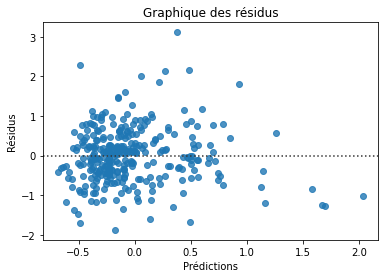

In [35]:
#On va faire une validation croisée pour affiner les hyperparamètres de chaque modèle tout en évitant l'overfitting
#DummyRegressor est exclu de cette phase
from sklearn.model_selection import GridSearchCV

#Pour enregistrer les résultats
résultats_gridSearch = []

#On utilise "neg" car ce sont des métriques que GridSearch va chercher à maximiser, or nous cherchons à minimiser les erreurs donc le passage au négatif contourne ce problème
scoring = {'MSE' : 'neg_mean_squared_error',
           'MAE' : 'neg_mean_absolute_error',
           'RMSE' : 'neg_root_mean_squared_error',
           'R²' : 'r2'}

#On commence par Ridge()
params_Ridge = {'alpha' : [550, 600, 650], #J'ai un peu tâtonné pour trouver la meilleure valeur 
                'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

#Le modèle
Ridge_gridSearch = GridSearchCV(Ridge(), params_Ridge, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
Ridge_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_Ridge = Ridge_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_Ridge = Ridge_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = Ridge_gridSearch.cv_results_
best_index = Ridge_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_Ridge)
train_MSE = mean_squared_error(y_train_scaled, y_train_Ridge)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_Ridge)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_Ridge)
test_MSE = mean_squared_error(y_test_scaled, y_test_Ridge)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_Ridge)

#Impression des meilleurs paramètres
print("Best params :", Ridge_gridSearch.best_params_)
print("Best estimator :", Ridge_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['Ridge', Ridge_gridSearch.best_params_, Ridge_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_Ridge
sns.residplot(x=y_test_Ridge, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

Best params : {'alpha': 0.1, 'max_iter': 1000, 'tol': 0.0001}
Best estimator : Lasso(alpha=0.1)
Temps d'ajustement : 0.0037897109985351564 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.6505229651991944
Test MSE : 0.6714815467884819
Test RMSE : 0.819439776181558
Test R² : 0.32851845321151796


Métriques à partir des prédictions :
Test MAE : 0.6343713481180389
Test MSE : 0.6758464942791162
Test RMSE : 0.8220988348605758
Test R² : 0.319220293699378


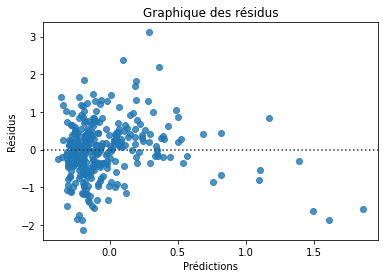

In [36]:
#On enchaîne avec Lasso()
params_Lasso = {'alpha' : [0.001, 0.01, 0.1, 1, 10],
                'tol' : [0.000001, 0.00001, 0.0001], 
                'max_iter' : [1000, 10000]}

#Le modèle
Lasso_gridSearch = GridSearchCV(Lasso(), params_Lasso, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
Lasso_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_Lasso = Lasso_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_Lasso = Lasso_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = Lasso_gridSearch.cv_results_
best_index = Lasso_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_Lasso)
train_MSE = mean_squared_error(y_train_scaled, y_train_Lasso)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_Lasso)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_Lasso)
test_MSE = mean_squared_error(y_test_scaled, y_test_Lasso)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_Lasso)

#Impression des meilleurs paramètres
print("Best params :", Lasso_gridSearch.best_params_)
print("Best estimator :", Lasso_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['Lasso', Lasso_gridSearch.best_params_, Lasso_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_Lasso
sns.residplot(x=y_test_Lasso, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

Best params : {'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 10000, 'tol': 1e-07}
Best estimator : ElasticNet(alpha=0.1, max_iter=10000, tol=1e-07)
Temps d'ajustement : 0.00840587615966797 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.6281316896019428
Test MSE : 0.6287302337178551
Test RMSE : 0.7929251123011902
Test R² : 0.3712697662821448


Métriques à partir des prédictions :
Test MAE : 0.6051640548269648
Test MSE : 0.6194943329822972
Test RMSE : 0.7870796230257122
Test R² : 0.37598378680290245


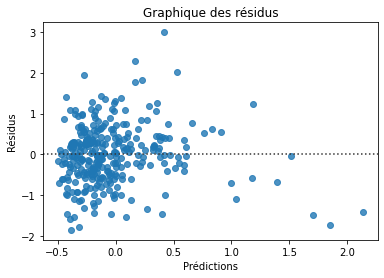

In [37]:
#On enchaîne avec ElasticNet()
params_EN = {'alpha' : [0.01, 0.1, 1],
             'l1_ratio' : np.arange(0.1, 1.1, 0.1), #Fourchette de 0.1 à 1 par pas de 0.1, problème de convergence pour l1_ratio = 0
             'tol' : [0.00000001, 0.0000001, 0.000001],
             'max_iter' : [10000]}

#Le modèle
EN_gridSearch = GridSearchCV(ElasticNet(), params_EN, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
EN_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_EN = EN_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_EN = EN_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = EN_gridSearch.cv_results_
best_index = EN_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_EN)
train_MSE = mean_squared_error(y_train_scaled, y_train_EN)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_EN)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_EN)
test_MSE = mean_squared_error(y_test_scaled, y_test_EN)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_EN)

#Impression des meilleurs paramètres
print("Best params :", EN_gridSearch.best_params_)
print("Best estimator :", EN_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['ElasticNet', EN_gridSearch.best_params_, EN_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_EN
sns.residplot(x=y_test_EN, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

Best params : {'max_depth': 9, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 85}
Best estimator : DecisionTreeRegressor(max_depth=9, min_samples_leaf=3, min_samples_split=85,
                      random_state=42)
Temps d'ajustement : 0.0075800418853759766 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.3919092375973685
Test MSE : 0.26331185516500716
Test RMSE : 0.513139216163613
Test R² : 0.7366881448349928


Métriques à partir des prédictions :
Test MAE : 0.46195745969920016
Test MSE : 0.37556214614564254
Test RMSE : 0.6128312542173764
Test R² : 0.6216965099103242


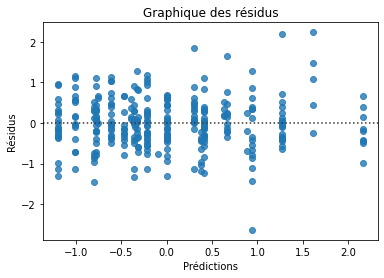

In [38]:
#On enchaîne avec DecisionTreeRegressor()
params_DTR = {'max_depth' : [8, 9, 10],
              'min_samples_split' : [80, 85, 90], #J'ai un peu tâtonné pour trouver la meilleure valeur
              'min_samples_leaf' : [1, 2, 3, 4, 5],
              'max_features' : ['sqrt', 'log2', None]}

#Le modèle
DTR_gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=42), params_DTR, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
DTR_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_DTR = DTR_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_DTR = DTR_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = DTR_gridSearch.cv_results_
best_index = DTR_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_DTR)
train_MSE = mean_squared_error(y_train_scaled, y_train_DTR)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_DTR)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_DTR)
test_MSE = mean_squared_error(y_test_scaled, y_test_DTR)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_DTR)

#Impression des meilleurs paramètres
print("Best params :", DTR_gridSearch.best_params_)
print("Best estimator :", DTR_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['DecisionTree', DTR_gridSearch.best_params_, DTR_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_DTR
sns.residplot(x=y_test_DTR, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

In [39]:
#On enchaîne avec SVR() et on change de stratégie
#Ce modèle est long à entraîner alors pour optimiser notre recherche des meilleurs hyperparamtètres, on va utiliser RandomizedSearchCV
#On pourra ainsi balayer assez large, et on affinera par la suite
from sklearn.model_selection import RandomizedSearchCV

params_randomSVR = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 
                    'C' : [0.1, 1, 10, 100],  
                    'gamma' : ['scale', 'auto', 0.001, 0.01, 0.1],  
                    'epsilon' : np.arange(0.1, 1.1, 0.1), #Fourchette de 0.1 à 1 par pas de 0.1
                    'degree' : [1, 2, 3]}

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomSVR_gridSearch = RandomizedSearchCV(SVR(), params_randomSVR, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomSVR_gridSearch.fit(X_train_oh, y_train_scaled)

    #Impression des meilleurs paramètres
    print("Best params :", randomSVR_gridSearch.best_params_)
    print("\n")

Best params : {'kernel': 'rbf', 'gamma': 0.1, 'epsilon': 0.2, 'degree': 3, 'C': 1}


Best params : {'kernel': 'rbf', 'gamma': 'auto', 'epsilon': 0.7000000000000001, 'degree': 2, 'C': 10}


Best params : {'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 0.4, 'degree': 3, 'C': 10}


Best params : {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.4, 'degree': 2, 'C': 10}


Best params : {'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 1.0, 'degree': 1, 'C': 1}




Best params : {'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
Best estimator : SVR(C=1, epsilon=0.2)
Temps d'ajustement : 0.08428192138671875 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.3204390889090908
Test MSE : 0.19120092801910368
Test RMSE : 0.4372652833453665
Test R² : 0.8087990719808963


Métriques à partir des prédictions :
Test MAE : 0.38613237666217126
Test MSE : 0.27601324347231193
Test RMSE : 0.5253696255707138
Test R² : 0.7219720507293769


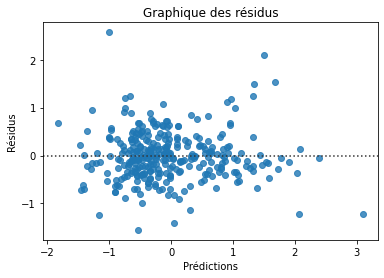

In [39]:
#Manifestement rbf est le meilleur noyau, donc degree est inutile, on affine la recherche à partir des best_params de RandomizedSearchCV
params_SVR = {'kernel' : ['rbf'], 
              'C' : [1, 10],
              'gamma' : ['auto', 'scale', 0.001],  
              'epsilon' : np.arange(0.2, 0.7, 0.1)} #Fourchette de 0.2 à 0.6 par pas de 0.1

#Le modèle
SVR_gridSearch = GridSearchCV(SVR(), params_SVR, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
SVR_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_SVR = SVR_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_SVR = SVR_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = SVR_gridSearch.cv_results_
best_index = SVR_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_SVR)
train_MSE = mean_squared_error(y_train_scaled, y_train_SVR)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_SVR)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_SVR)
test_MSE = mean_squared_error(y_test_scaled, y_test_SVR)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_SVR)

#Impression des meilleurs paramètres
print("Best params :", SVR_gridSearch.best_params_)
print("Best estimator :", SVR_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['SVR', SVR_gridSearch.best_params_, SVR_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_SVR
sns.residplot(x=y_test_SVR, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

Best params : {'alpha': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimator : KernelRidge(alpha=0.01, gamma=0.01, kernel='rbf')
Temps d'ajustement : 0.08625597953796386 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.2700379202783916
Test MSE : 0.13164981061908324
Test RMSE : 0.36283579015731515
Test R² : 0.8683501893809167


Métriques à partir des prédictions :
Test MAE : 0.38512350741969026
Test MSE : 0.2795954729868484
Test RMSE : 0.5287678819546895
Test R² : 0.7183636734167022


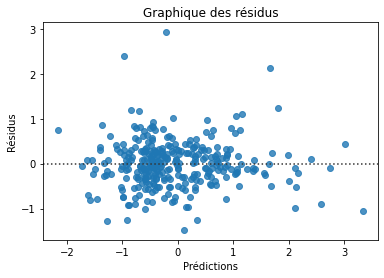

In [40]:
#On enchaîne avec KernelRidge(), plus rapide à entraîner donc on peut se passer de RandomizedSearchCV
#J'ai testé différentes valeurs de degree également, mais comme "rbf" est le kernel le plus performant il n'a pas d'impact
#Je l'ai donc retiré pour accélérer le temps de calcul
params_KR = {'alpha' : [0.001, 0.01, 1], 
             'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
             'gamma' : [0.001, 0.01, 0.1]}

#Le modèle
KR_gridSearch = GridSearchCV(KernelRidge(), params_KR, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
KR_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_KR = KR_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_KR = KR_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = KR_gridSearch.cv_results_
best_index = KR_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_KR)
train_MSE = mean_squared_error(y_train_scaled, y_train_KR)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_KR)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_KR)
test_MSE = mean_squared_error(y_test_scaled, y_test_KR)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_KR)

#Impression des meilleurs paramètres
print("Best params :", KR_gridSearch.best_params_)
print("Best estimator :", KR_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['KernelRidge', KR_gridSearch.best_params_, KR_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_KR
sns.residplot(x=y_test_KR, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

In [42]:
#On enchaîne avec RandomForestRegressor() et on repasse sur la stratégie RandomizedSearchCV
#Le nombre d'hyperparamètres à tester étant plus élevé, le temps de calcul augmente également
params_randomRFR = {'n_estimators' : np.arange(50, 501, 50), #Fourchette de 50 à 500 par pas de 50
                    'max_features' : ['sqrt', 'log2', None],
                    'max_depth' : np.arange(3, 16, 1), #Fourchette de 3 à 15 par pas de 1
                    'min_samples_split' : np.arange(2, 11, 1), #Fourchette de 2 à 10 par pas de 1
                    'min_samples_leaf' : np.arange(1, 6, 1)} #Fourchette de 1 à 5 par pas de 1

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomRFR_gridSearch = RandomizedSearchCV(RandomForestRegressor(random_state=42), params_randomRFR, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomRFR_gridSearch.fit(X_train_oh, y_train_scaled)

    #Impression des meilleurs paramètres
    print("Best params :", randomRFR_gridSearch.best_params_)
    print("\n")

Best params : {'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}


Best params : {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 14}


Best params : {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 15}


Best params : {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 12}


Best params : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 8}




In [43]:
#On y voit un peu plus clair mais pas pour tous les paramètres, on va réessayer en ajustant certaines valeurs à tester
params_randomRFR = {'n_estimators' : [100, 150, 200, 250],
                    'max_features' : [None],
                    'max_depth' : [12, 13, 14, 15],
                    'min_samples_split' : np.arange(2, 11, 1), #Fourchette de 2 à 10 par pas de 1
                    'min_samples_leaf' : [2]}

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomRFR_gridSearch = RandomizedSearchCV(RandomForestRegressor(random_state=42), params_randomRFR, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomRFR_gridSearch.fit(X_train_oh, y_train_scaled)

    #Impression des meilleurs paramètres
    print("Best params :", randomRFR_gridSearch.best_params_)
    print("\n")

Best params : {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15}


Best params : {'n_estimators': 250, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 13}


Best params : {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15}


Best params : {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 14}


Best params : {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15}




Best params : {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best estimator : RandomForestRegressor(max_depth=15, max_features=None, min_samples_leaf=2,
                      random_state=42)
Temps d'ajustement : 1.2095101356506348 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.18880232180098347
Test MSE : 0.06763283681181095
Test RMSE : 0.26006314004835623
Test R² : 0.932367163188189


Métriques à partir des prédictions :
Test MAE : 0.394618582471209
Test MSE : 0.28641167426932623
Test RMSE : 0.5351744334974591
Test R² : 0.7114977185786575


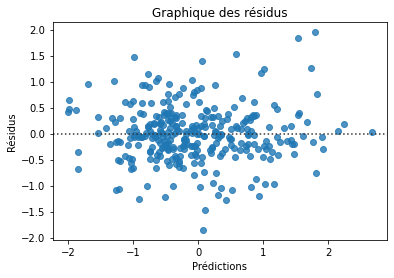

In [41]:
#On affine la recherche à partir des best_params de RandomizedSearchCV
params_RFR = {'n_estimators': [100, 150, 200, 250],
              'max_depth' : [13, 14, 15], 
              'min_samples_split' : [2, 3, 4],
              'min_samples_leaf' : [2],
              'max_features' : [None]}

#Le modèle
RFR_gridSearch = GridSearchCV(RandomForestRegressor(random_state=42), params_RFR, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
RFR_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_RFR = RFR_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_RFR = RFR_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = RFR_gridSearch.cv_results_
best_index = RFR_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_RFR)
train_MSE = mean_squared_error(y_train_scaled, y_train_RFR)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_RFR)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_RFR)
test_MSE = mean_squared_error(y_test_scaled, y_test_RFR)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_RFR)

#Impression des meilleurs paramètres
print("Best params :", RFR_gridSearch.best_params_)
print("Best estimator :", RFR_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['RandomForest', RFR_gridSearch.best_params_, RFR_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_RFR
sns.residplot(x=y_test_RFR, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

In [45]:
#Enfin, on termine par XGBRegressor()
#Encore une fois, beaucoup de paramètres à considérer alors on conserve la même stratégie
params_randomXGB = {'learning_rate' : np.arange(0.01, 0.21, 0.01), #Fourchette de 0.01 à 0.2 par pas de 0.01
                    'n_estimators' : np.arange(50, 501, 50), #Fourchette de 50 à 500 par pas de 50
                    'max_depth' : np.arange(3, 16, 1), #Fourchette de 5 à 15 par pas de 1
                    'min_child_weight' : np.arange(1, 6, 1), #Fourchette de 1 à 5 par pas de 1
                    'subsample' : np.arange(0.6, 1.01, 0.1), #Fourchette de 0.6 à 1.0 par pas de 0.1
                    'colsample_bytree' : np.arange(0.6, 1.01, 0.1)} #Fourchette de 0.6 à 1.0 par pas de 0.1

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomXGB_gridSearch = RandomizedSearchCV(XGBRegressor(), params_randomXGB, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomXGB_gridSearch.fit(X_train_oh, y_train_scaled)

    #Impression des meilleurs paramètres
    print("Best params :", randomXGB_gridSearch.best_params_)
    print("\n")

Best params : {'subsample': 0.7999999999999999, 'n_estimators': 450, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.02, 'colsample_bytree': 0.6}


Best params : {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.060000000000000005, 'colsample_bytree': 0.8999999999999999}


Best params : {'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7999999999999999}


Best params : {'subsample': 0.9999999999999999, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


Best params : {'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 0.9999999999999999}




In [46]:
#Comme avant, on ajuste certaines valeurs à tester
params_randomXGB = {'learning_rate' : np.arange(0.03, 0.11, 0.01), #Fourchette de 0.03 à 0.1 par pas de 0.01
                    'n_estimators' : np.arange(250, 451, 50), #Fourchette de 250 à 450 par pas de 50
                    'max_depth' : [3],
                    'min_child_weight' : np.arange(1, 6, 1), #Fourchette de 1 à 5 par pas de 1
                    'subsample' : np.arange(0.6, 1.01, 0.1), #Fourchette de 0.6 à 1.0 par pas de 0.1
                    'colsample_bytree' : [0.6, 0.7, 0.8, 0.9]}

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomXGB_gridSearch = RandomizedSearchCV(XGBRegressor(), params_randomXGB, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomXGB_gridSearch.fit(X_train_oh, y_train_scaled)

    #Impression des meilleurs paramètres
    print("Best params :", randomXGB_gridSearch.best_params_)
    print("\n")

Best params : {'subsample': 0.7999999999999999, 'n_estimators': 450, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


Best params : {'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.6}


Best params : {'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.9}


Best params : {'subsample': 0.9999999999999999, 'n_estimators': 350, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.060000000000000005, 'colsample_bytree': 0.8}


Best params : {'subsample': 0.6, 'n_estimators': 450, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.9}




Best params : {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.7}
Best estimator : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Temps d'ajustement : 0.3253459453582764 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.2

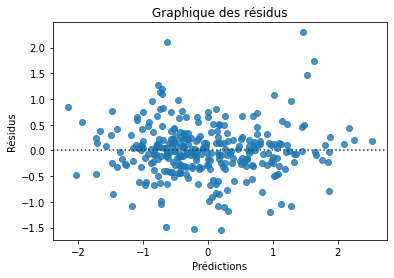

In [42]:
#On affine la recherche à partir des best_params de RandomizedSearchCV
params_XGB = {'learning_rate' : [0.04, 0.05], 
              'n_estimators' : [350, 400],
              'max_depth' : [3],  
              'min_child_weight' : np.arange(1, 6, 1), #Fourchette de 1 à 5 par pas de 1  
              'subsample' : [0.6, 0.7, 0.8],  
              'colsample_bytree' : [0.9]}

#Le modèle
XGB_gridSearch = GridSearchCV(XGBRegressor(), params_XGB, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
XGB_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_XGB = XGB_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_XGB = XGB_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = XGB_gridSearch.cv_results_
best_index = XGB_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_XGB)
train_MSE = mean_squared_error(y_train_scaled, y_train_XGB)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_XGB)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_XGB)
test_MSE = mean_squared_error(y_test_scaled, y_test_XGB)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_XGB)

#Impression des meilleurs paramètres
print("Best params :", XGB_gridSearch.best_params_)
print("Best estimator :", XGB_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['XGBoost', XGB_gridSearch.best_params_, XGB_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_XGB
sns.residplot(x=y_test_XGB, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

In [43]:
#Pour y voir plus clair
résultats_gridSearch = pd.DataFrame(résultats_gridSearch, 
                                    columns=['Modèle', 'Best params', 'Best estimator', 'Fit time', 'Train MAE', 'Train MSE', 'Train RMSE', 'Train R²', 'Test MAE', 'Test MSE', 'Test RMSE', 'Test R²'])
résultats_gridSearch

,Modèle,Best params,Best estimator,Fit time,Train MAE,Train MSE,Train RMSE,Train R²,Test MAE,Test MSE,Test RMSE,Test R²
0,Ridge,"{'alpha': 600, 'solver': 'auto'}",Ridge(alpha=600),0.004,0.598,0.574,0.758,0.426,0.575,0.580,0.762,0.415
1,Lasso,"{'alpha': 0.1, 'max_iter': 1000, 'tol': 0.0001}",Lasso(alpha=0.1),0.004,0.651,0.671,0.819,0.329,0.634,0.676,0.822,0.319
2,ElasticNet,"{'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 10...","ElasticNet(alpha=0.1, max_iter=10000, tol=1e-07)",0.008,0.628,0.629,0.793,0.371,0.605,0.619,0.787,0.376
3,DecisionTree,"{'max_depth': 9, 'max_features': None, 'min_sa...","DecisionTreeRegressor(max_depth=9, min_samples...",0.008,0.392,0.263,0.513,0.737,0.462,0.376,0.613,0.622
4,SVR,"{'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'ke...","SVR(C=1, epsilon=0.2)",0.084,0.320,0.191,0.437,0.809,0.386,0.276,0.525,0.722
5,KernelRidge,"{'alpha': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","KernelRidge(alpha=0.01, gamma=0.01, kernel='rbf')",0.086,0.270,0.132,0.363,0.868,0.385,0.280,0.529,0.718
6,RandomForest,"{'max_depth': 15, 'max_features': None, 'min_s...","(DecisionTreeRegressor(max_depth=15, min_sampl...",1.210,0.189,0.068,0.260,0.932,0.395,0.286,0.535,0.711
7,XGBoost,"{'colsample_bytree': 0.9, 'learning_rate': 0.0...","XGBRegressor(base_score=None, booster=None, ca...",0.325,0.279,0.134,0.366,0.866,0.359,0.258,0.508,0.741


XGBoost présente les meilleurs résultats sur le jeu de test, avec une différence acceptable par rapport aux résultats d'entraînement, ce qui indique qu'il généralise bien tout en évitant le surajustement.
# V) Choix du modèle et feature importance <a class="anchor" id="v"></a>

In [44]:
#On utilise les best_params
XGB = XGBRegressor(**XGB_gridSearch.best_params_)

#On fit
XGB.fit(X_train_oh, y_train_scaled)

#On predict
y_pred_XGB = XGB.predict(X_test_oh)

#Pour vérifier
MAE = mean_absolute_error(y_test_scaled, y_pred_XGB)
MSE = mean_squared_error(y_test_scaled, y_pred_XGB)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test_scaled, y_pred_XGB, multioutput="variance_weighted")
print("MAE =", MAE)        
print("MSE =", MSE)
print("RMSE =", RMSE)
print("R² =", R2)

MAE = 0.35939107064501963
MSE = 0.2575653094670846
RMSE = 0.5075089255048473
R² = 0.7405546418950347


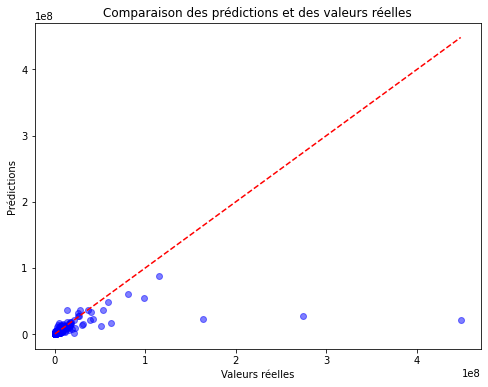

In [45]:
#Pour comparer les valeurs prédites et les valeurs réelles, inverse_transform le scaler
y_test_orig = scalery.inverse_transform(y_test_scaled.reshape(-1, 1))
y_pred_XGB_orig = scalery.inverse_transform(y_pred_XGB.reshape(-1, 1))

#Exponentielle pour revenir sur la transformation au log
y_test_orig = np.exp(y_test_orig)
y_pred_XGB_orig = np.exp(y_pred_XGB_orig)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_XGB_orig, color='blue', alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], color='red', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des prédictions et des valeurs réelles')
plt.show()

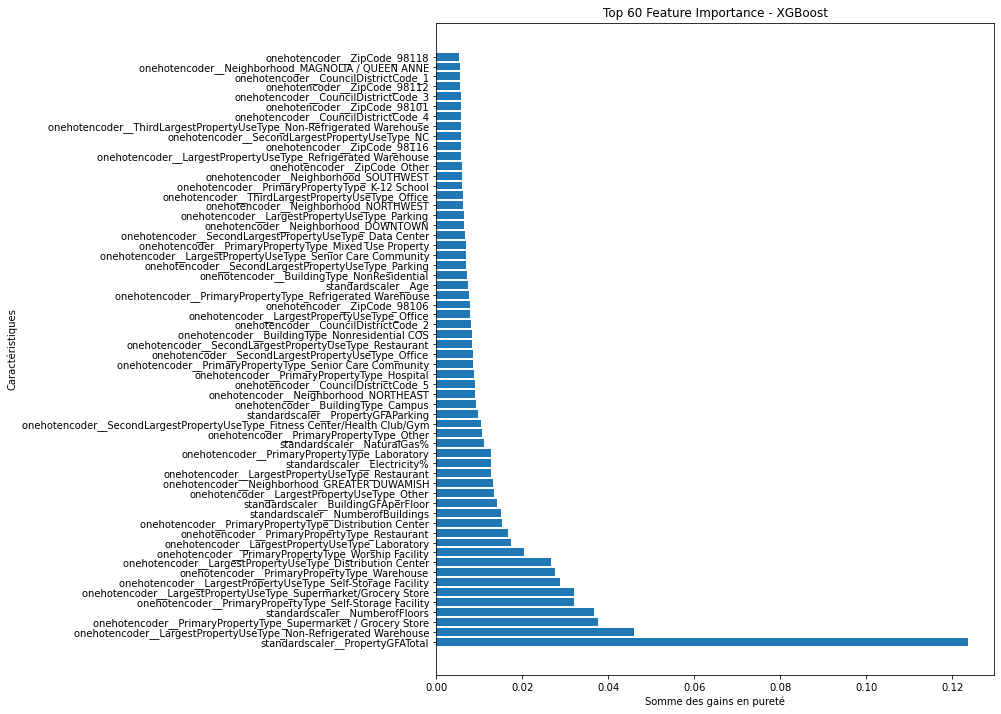

In [46]:
#On constate que les 3 valeurs les plus élevées sont très mal prédite, mais pas de souci pour le reste
#Pour visualiser la feature importance on a besoin de récupérer les noms des colonnes du one-hot encoder
noms_features_oh = preprocessor_oh.get_feature_names_out()

#Il y en a beaucoup alors on ne va afficher que le top 60
indices_rangés_XGB = np.argsort(XGB.feature_importances_)[::-1]
top_features = [noms_features_oh[i] for i in indices_rangés_XGB[:60]]
top_importances = [XGB.feature_importances_[i] for i in indices_rangés_XGB[:60]]

#On visualise
plt.figure(figsize=(10, 12))
plt.barh(top_features, top_importances)
plt.xlabel('Somme des gains en pureté')
plt.ylabel('Caractéristiques')
plt.title('Top 60 Feature Importance - XGBoost')
plt.show()

On constate que PropertyGFATotal a beaucoup plus de poids que le reste des variables, suivi de divers PropertyUseTypes. On cherche désormais à analyser l'influence d'ENERGYSTARScore qu'on a mis de côté plus tôt.
# VI) ENERGYSTARScore <a class="anchor" id="vi"></a>

In [47]:
#On ajoute ENERGYSTARScore à X
X['ENERGYSTARScore'] = ess
X

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingGFAperFloor,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SteamUse%,Electricity%,NaturalGas%,ENERGYSTARScore
0,NonResidential,Hotel,98101,7,DOWNTOWN,89,1,12,88434,0,7369.500,Hotel,NC,NC,27.730,54.606,17.664,60
1,NonResidential,Hotel,98101,7,DOWNTOWN,20,1,11,103566,15064,8045.636,Hotel,Parking,Restaurant,0.000,38.661,61.339,61
2,NonResidential,Hotel,98101,7,DOWNTOWN,47,1,41,956110,196718,18521.756,Hotel,NC,NC,29.711,68.231,2.058,43
3,NonResidential,Hotel,98101,7,DOWNTOWN,90,1,10,61320,0,6132.000,Hotel,NC,NC,32.591,40.752,26.657,56
4,NonResidential,Hotel,98121,7,DOWNTOWN,36,1,18,175580,62000,6310.000,Hotel,Parking,Swimming Pool,0.000,37.880,62.120,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,Nonresidential COS,Other,98126,1,DELRIDGE,34,1,1,18261,0,18261.000,Other,NC,NC,0.000,67.844,32.156,<NA>
1541,Nonresidential COS,Other,98104,2,DOWNTOWN,12,1,1,16000,0,16000.000,Other,NC,NC,0.000,41.730,58.270,<NA>
1542,Nonresidential COS,Other,98119,7,MAGNOLIA / QUEEN ANNE,42,1,1,13157,0,13157.000,Other,Fitness Center/Health Club/Gym,Swimming Pool,0.000,31.082,68.918,<NA>
1543,Nonresidential COS,Mixed Use Property,98108,1,GREATER DUWAMISH,27,1,1,14101,0,14101.000,Other,Fitness Center/Health Club/Gym,Other,0.000,48.490,51.510,<NA>


In [48]:
#On filtre les valeurs manquantes
X_ess = X[X['ENERGYSTARScore'].notnull()]
y_ess = y[y.index.isin(list(X_ess.index))]

In [49]:
#On ajoute aux variables quantitatives pour les encoders
var_quanti_ess = var_quanti.append(pd.Index(['ENERGYSTARScore']))
var_quanti_ess

Index(['Age', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'BuildingGFAperFloor', 'SteamUse%',
       'Electricity%', 'NaturalGas%', 'ENERGYSTARScore'],
      dtype='object')

In [50]:
#Les encoders
preprocessor_oh_ess = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False), var_quali),
                                          (StandardScaler(), var_quanti_ess))

preprocessor_b_ess = make_column_transformer((BinaryEncoder(), var_quali), 
                                         (StandardScaler(), var_quanti_ess))

preprocessor_t_ess = make_column_transformer((TargetEncoder(), var_quali),
                                         (StandardScaler(), var_quanti_ess))

In [51]:
#On sépare jeu de test et jeu d'entraînement
X_train, X_test, y_train, y_test = train_test_split(X_ess, y_ess, test_size=0.2, random_state=2)
 
#Transformation des X
X_train_oh_ess = preprocessor_oh_ess.fit_transform(X_train)
X_test_oh_ess = preprocessor_oh_ess.transform(X_test)

X_train_b_ess = preprocessor_b_ess.fit_transform(X_train)
X_test_b_ess = preprocessor_b_ess.transform(X_test)

X_train_t_ess = preprocessor_t_ess.fit_transform(X_train, y_train)
X_test_t_ess = preprocessor_t_ess.transform(X_test)

#Transformation des y
y_train_ess = scalery.fit_transform(y_train.values.reshape(-1, 1)).flatten() #Pour un résultat unidimensionnel
y_test_ess = scalery.transform(y_test.values.reshape(-1, 1)).flatten() #Idem

In [52]:
#Encore une fois, les dimensions diffèrent d'un encodage à l'autre
print(X_train_oh_ess.shape)
print(X_train_b_ess.shape)
print(X_train_t_ess.shape)

(796, 120)
(796, 43)
(796, 18)


In [53]:
#On vérifie pour Target
noms_features_ess = np.concatenate((var_quali, var_quanti_ess))
pd.DataFrame(X_train_t_ess, columns=noms_features_ess)

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingGFAperFloor,SteamUse%,Electricity%,NaturalGas%,ENERGYSTARScore
0,14.987,13.901,14.417,14.724,14.793,13.901,14.615,14.848,0.260,-0.104,-0.540,-0.466,-0.362,-0.066,-0.245,-0.487,0.581,-2.147
1,14.987,14.634,15.614,15.558,15.769,15.402,15.073,14.848,-1.120,-0.104,-0.137,-0.206,0.004,-0.244,-0.245,1.069,-0.978,0.309
2,14.987,13.971,14.876,14.512,14.375,13.982,14.533,14.848,-0.492,-0.104,-0.540,-0.462,-0.362,-0.052,-0.245,1.069,-0.978,0.343
3,14.987,13.971,14.319,14.512,14.375,13.982,15.073,15.089,1.452,-0.104,-0.540,-0.305,-0.362,0.492,-0.245,1.069,-0.978,-0.210
4,14.987,14.974,14.699,14.512,14.375,14.978,14.615,14.848,-1.308,-0.104,-0.540,0.109,-0.362,1.926,-0.245,-0.035,0.129,-1.317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,14.987,15.860,15.614,15.558,15.769,15.866,14.615,14.848,1.671,-0.104,0.400,-0.321,-0.362,-0.395,-0.245,0.590,-0.498,1.035
792,14.987,14.853,15.449,15.558,14.946,14.824,14.615,14.848,0.041,-0.104,-0.540,0.098,-0.362,1.885,-0.245,0.447,-0.354,0.101
793,14.987,14.819,14.819,14.664,14.892,15.402,14.868,15.432,1.170,-0.104,-0.406,-0.492,-0.362,-0.334,-0.245,-0.498,0.593,-0.106
794,14.987,14.634,14.419,14.512,14.375,15.402,14.615,14.848,-0.210,-0.104,-0.406,-0.469,-0.362,-0.296,-0.245,1.069,-0.978,0.205


In [54]:
#On centre et réduit
X_train_t_ess[:, :8] = scalerx.fit_transform(X_train_t_ess[:, :8])
X_test_t_ess[:, :8] = scalerx.transform(X_test_t_ess[:, :8])
pd.DataFrame(X_train_t_ess, columns=noms_features_ess)

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingGFAperFloor,SteamUse%,Electricity%,NaturalGas%,ENERGYSTARScore
0,-0.178,-1.384,-1.252,-0.647,-0.481,-1.814,-0.722,-0.404,0.260,-0.104,-0.540,-0.466,-0.362,-0.066,-0.245,-0.487,0.581,-2.147
1,-0.178,-0.447,1.093,1.236,1.509,0.704,0.124,-0.404,-1.120,-0.104,-0.137,-0.206,0.004,-0.244,-0.245,1.069,-0.978,0.309
2,-0.178,-1.294,-0.354,-1.126,-1.334,-1.678,-0.873,-0.404,-0.492,-0.104,-0.540,-0.462,-0.362,-0.052,-0.245,1.069,-0.978,0.343
3,-0.178,-1.294,-1.444,-1.126,-1.334,-1.678,0.124,0.372,1.452,-0.104,-0.540,-0.305,-0.362,0.492,-0.245,1.069,-0.978,-0.210
4,-0.178,-0.012,-0.700,-1.126,-1.334,-0.007,-0.722,-0.404,-1.308,-0.104,-0.540,0.109,-0.362,1.926,-0.245,-0.035,0.129,-1.317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,-0.178,1.123,1.093,1.236,1.509,1.483,-0.722,-0.404,1.671,-0.104,0.400,-0.321,-0.362,-0.395,-0.245,0.590,-0.498,1.035
792,-0.178,-0.166,0.769,1.236,-0.169,-0.265,-0.722,-0.404,0.041,-0.104,-0.540,0.098,-0.362,1.885,-0.245,0.447,-0.354,0.101
793,-0.178,-0.210,-0.465,-0.783,-0.280,0.704,-0.254,1.481,1.170,-0.104,-0.406,-0.492,-0.362,-0.334,-0.245,-0.498,0.593,-0.106
794,-0.178,-0.447,-1.248,-1.126,-1.334,0.704,-0.722,-0.404,-0.210,-0.104,-0.406,-0.469,-0.362,-0.296,-0.245,1.069,-0.978,0.205


In [55]:
#On teste les encoders, on va s'y prendre différemment car il n'y a qu'un seul modèle à tester
encoders_ess = {'OneHot': (X_train_oh_ess, X_test_oh_ess),
               'Binaire': (X_train_b_ess, X_test_b_ess),
               'Target': (X_train_t_ess, X_test_t_ess)}

#Pour enregistrer les résultats
résultats_ess = []

#Le modèle
XGBoost = XGBRegressor()

# Boucle sur les données pour chaque encodeur
for nom_encoder, (X_train, X_test) in encoders_ess.items():
    # On fit
    XGBoost.fit(X_train, y_train_ess)
    y_pred = XGBoost.predict(X_test)

    # Evaluation des performances
    print(f"Performance avec l'encodeur {nom_encoder} :")
    MAE = mean_absolute_error(y_test_ess, y_pred)
    MSE = mean_squared_error(y_test_ess, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test_ess, y_pred, multioutput="variance_weighted")
    print("MAE =", MAE)
    print("MSE =", MSE)
    print("RMSE =", RMSE)
    print("R² =", R2)
    print("\n")

    # Ajout des résultats à la liste
    résultats_ess.append({'Encoder': nom_encoder, 'Modèle': 'XGBRegressor', 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE, 'R²': R2})

Performance avec l'encodeur OneHot :
MAE = 0.36565077157743126
MSE = 0.2475368115956576
RMSE = 0.49753071422341116
R² = 0.7611621557089185


Performance avec l'encodeur Binaire :
MAE = 0.40884681412180995
MSE = 0.3176932347523161
RMSE = 0.5636428255130337
R² = 0.6934711777008493


Performance avec l'encodeur Target :
MAE = 0.39343817427391475
MSE = 0.27987763829422596
RMSE = 0.5290346286342945
R² = 0.7299578540881368




In [56]:
résultats_ess = pd.DataFrame(résultats_ess, columns=['Encoder', 'Modèle', 'MAE', 'MSE', 'RMSE', 'R²'])
résultats_ess

,Encoder,Modèle,MAE,MSE,RMSE,R²
0,OneHot,XGBRegressor,0.366,0.248,0.498,0.761
1,Binaire,XGBRegressor,0.409,0.318,0.564,0.693
2,Target,XGBRegressor,0.393,0.280,0.529,0.730


In [53]:
#On reste sur l'encoder OneHot
#On comparera  ensuite les résultats obtenus avec ceux des du modèle retenu précédemment
params_randomXGB_ess = {'learning_rate' : np.arange(0.01, 0.21, 0.01), #Fourchette de 0.01 à 0.2 par pas de 0.01
                        'n_estimators' : np.arange(50, 501, 50), #Fourchette de 50 à 500 par pas de 50
                        'max_depth' : np.arange(3, 16, 1), #Fourchette de 3 à 15 par pas de 1
                        'min_child_weight' : np.arange(1, 6, 1), #Fourchette de 1 à 5 par pas de 1
                        'subsample' : np.arange(0.6, 1.01, 0.1), #Fourchette de 0.6 à 1.0 par pas de 0.1
                        'colsample_bytree' : np.arange(0.6, 1.01, 0.1)} #Fourchette de 0.6 à 1.0 par pas de 0.1

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomXGB_ess_gridSearch = RandomizedSearchCV(XGBRegressor(), params_randomXGB_ess, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomXGB_ess_gridSearch.fit(X_train_oh_ess, y_train_ess)

    #Impression des meilleurs paramètres
    print("Best params :", randomXGB_ess_gridSearch.best_params_)
    print("\n")

Best params : {'subsample': 0.8999999999999999, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.03, 'colsample_bytree': 0.7}


Best params : {'subsample': 0.7999999999999999, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.9999999999999999}


Best params : {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.8999999999999999}


Best params : {'subsample': 0.7999999999999999, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.04, 'colsample_bytree': 0.7999999999999999}


Best params : {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.060000000000000005, 'colsample_bytree': 0.7}




In [54]:
#On progresse
params_randomXGB_ess = {'learning_rate' : np.arange(0.02, 0.07, 0.01), #Fourchette de 0.02 à 0.06 par pas de 0.01
                        'n_estimators' : np.arange(200, 501, 50), #Fourchette de 200 à 500 par pas de 50
                        'max_depth' : [3, 4, 5],
                        'min_child_weight' : np.arange(1, 6, 1), #Fourchette de 1 à 5 par pas de 1
                        'subsample' : [0.7, 0.8, 0.9],
                        'colsample_bytree' : np.arange(0.7, 1.01, 0.1)} #Fourchette de 0.7 à 1.0 par pas de 0.1

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomXGB_ess_gridSearch = RandomizedSearchCV(XGBRegressor(), params_randomXGB_ess, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomXGB_ess_gridSearch.fit(X_train_oh_ess, y_train_ess)

    #Impression des meilleurs paramètres
    print("Best params :", randomXGB_ess_gridSearch.best_params_)
    print("\n")

Best params : {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.8999999999999999}


Best params : {'subsample': 0.8, 'n_estimators': 350, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.039999999999999994, 'colsample_bytree': 0.8999999999999999}


Best params : {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.7999999999999999}


Best params : {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.039999999999999994, 'colsample_bytree': 0.8999999999999999}


Best params : {'subsample': 0.7, 'n_estimators': 450, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.02, 'colsample_bytree': 0.8999999999999999}




In [63]:
#Une dernière fois, car il y a toujours pas mal d'incertitudes
params_randomXGB_ess = {'learning_rate' : [0.02, 0.03, 0.04],
                        'n_estimators' : [np.arange(200, 501, 50)], #Fourchette de 200 à 500 par pas de 50
                        'max_depth' : [3, 4, 5],
                        'min_child_weight' : [1, 2, 3],
                        'subsample' : [0.7, 0.8],
                        'colsample_bytree' : [0.9]}

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomXGB_ess_gridSearch = RandomizedSearchCV(XGBRegressor(), params_randomXGB_ess, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomXGB_ess_gridSearch.fit(X_train_oh_ess, y_train_ess)

    #Impression des meilleurs paramètres
    print("Best params :", randomXGB_ess_gridSearch.best_params_)
    print("\n")

Best params : {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.9}


Best params : {'subsample': 0.7, 'n_estimators': 450, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.9}


Best params : {'subsample': 0.7, 'n_estimators': 450, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.9}


Best params : {'subsample': 0.8, 'n_estimators': 450, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.02, 'colsample_bytree': 0.9}


Best params : {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.9}




Best params : {'colsample_bytree': 0.9, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 450, 'subsample': 0.7}
Best estimator : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=450, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Temps d'ajustement : 0.7977149963378907 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.1

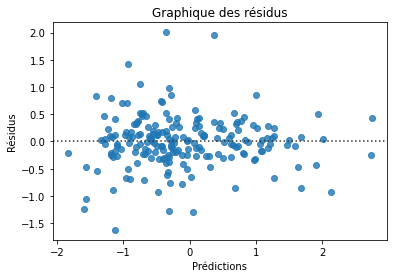

In [57]:
#On affine la recherche à partir des best_params de RandomizedSearchCV
params_ess_XGB = {'learning_rate' : [0.02],
                  'n_estimators' : [400, 450],
                  'max_depth' : [3, 4, 5],
                  'min_child_weight' : [3],
                  'subsample' : [0.7, 0.8],
                  'colsample_bytree' : [0.9]}

#Le modèle
XGB_ess_gridSearch = GridSearchCV(XGBRegressor(), params_ess_XGB, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
XGB_ess_gridSearch.fit(X_train_oh_ess, y_train_ess)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_XGB_ess = XGB_ess_gridSearch.predict(X_train_oh_ess) #Jeu d'entraînement pour voir s'il y a overfit
y_test_XGB_ess = XGB_ess_gridSearch.predict(X_test_oh_ess) #Jeu de test

#Résultats de la validation croisée
cv_results = XGB_ess_gridSearch.cv_results_
best_index = XGB_ess_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_ess, y_train_XGB_ess)
train_MSE = mean_squared_error(y_train_ess, y_train_XGB_ess)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_ess, y_train_XGB_ess)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_ess, y_test_XGB_ess)
test_MSE = mean_squared_error(y_test_ess, y_test_XGB_ess)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_ess, y_test_XGB_ess)

#Impression des meilleurs paramètres
print("Best params :", XGB_ess_gridSearch.best_params_)
print("Best estimator :", XGB_ess_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.loc[len(résultats_gridSearch)] = ['XGBoost_ESS', XGB_ess_gridSearch.best_params_, XGB_ess_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2]

#Pour visualiser les résidus
résidus = y_test_ess - y_test_XGB_ess
sns.residplot(x=y_test_XGB_ess, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

In [58]:
résultats_gridSearch

,Modèle,Best params,Best estimator,Fit time,Train MAE,Train MSE,Train RMSE,Train R²,Test MAE,Test MSE,Test RMSE,Test R²
0,Ridge,"{'alpha': 600, 'solver': 'auto'}",Ridge(alpha=600),0.004,0.598,0.574,0.758,0.426,0.575,0.580,0.762,0.415
1,Lasso,"{'alpha': 0.1, 'max_iter': 1000, 'tol': 0.0001}",Lasso(alpha=0.1),0.004,0.651,0.671,0.819,0.329,0.634,0.676,0.822,0.319
2,ElasticNet,"{'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 10...","ElasticNet(alpha=0.1, max_iter=10000, tol=1e-07)",0.008,0.628,0.629,0.793,0.371,0.605,0.619,0.787,0.376
3,DecisionTree,"{'max_depth': 9, 'max_features': None, 'min_sa...","DecisionTreeRegressor(max_depth=9, min_samples...",0.008,0.392,0.263,0.513,0.737,0.462,0.376,0.613,0.622
4,SVR,"{'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'ke...","SVR(C=1, epsilon=0.2)",0.084,0.320,0.191,0.437,0.809,0.386,0.276,0.525,0.722
5,KernelRidge,"{'alpha': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","KernelRidge(alpha=0.01, gamma=0.01, kernel='rbf')",0.086,0.270,0.132,0.363,0.868,0.385,0.280,0.529,0.718
6,RandomForest,"{'max_depth': 15, 'max_features': None, 'min_s...","(DecisionTreeRegressor(max_depth=15, min_sampl...",1.210,0.189,0.068,0.260,0.932,0.395,0.286,0.535,0.711
7,XGBoost,"{'colsample_bytree': 0.9, 'learning_rate': 0.0...","XGBRegressor(base_score=None, booster=None, ca...",0.325,0.279,0.134,0.366,0.866,0.359,0.258,0.508,0.741
8,XGBoost_ESS,"{'colsample_bytree': 0.9, 'learning_rate': 0.0...","XGBRegressor(base_score=None, booster=None, ca...",0.798,0.179,0.056,0.236,0.944,0.337,0.229,0.478,0.779


In [59]:
#Les métriques d'entraînement sont meilleurs, ce qui signifie que la nouvelle variable est informative et aide à mieux capturer les variations dans le jeu d'entraînement
#Les métriques de test sont meilleurs également mais l'écart entre train et test a augmenté, ce qui peut indiquer du sur-ajustement
#On cherche désormais à déterminer l'importance d'ENERGYSTARScore
XGB_ess = XGBRegressor(**XGB_ess_gridSearch.best_params_)

#On fit
XGB_ess.fit(X_train_oh_ess, y_train_ess)

#On predict
y_pred_XGB_ess = XGB_ess.predict(X_test_oh_ess)

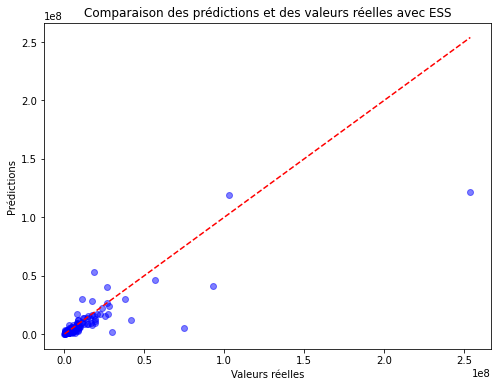

In [60]:
#Pour comparer les valeurs prédites et les valeurs réelles, inverse_transform le scaler
y_test_ess_orig = scalery.inverse_transform(y_test_ess.reshape(-1, 1))
y_pred_XGB_ess_orig = scalery.inverse_transform(y_pred_XGB_ess.reshape(-1, 1))

#Exponentielle pour revenir sur la transformation au log
y_test_ess_orig = np.exp(y_test_ess_orig)
y_pred_XGB_ess_orig = np.exp(y_pred_XGB_ess_orig)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_ess_orig, y_pred_XGB_ess_orig, color='blue', alpha=0.5)
plt.plot([y_test_ess_orig.min(), y_test_ess_orig.max()], [y_test_ess_orig.min(), y_test_ess_orig.max()], color='red', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des prédictions et des valeurs réelles avec ESS')
plt.show()

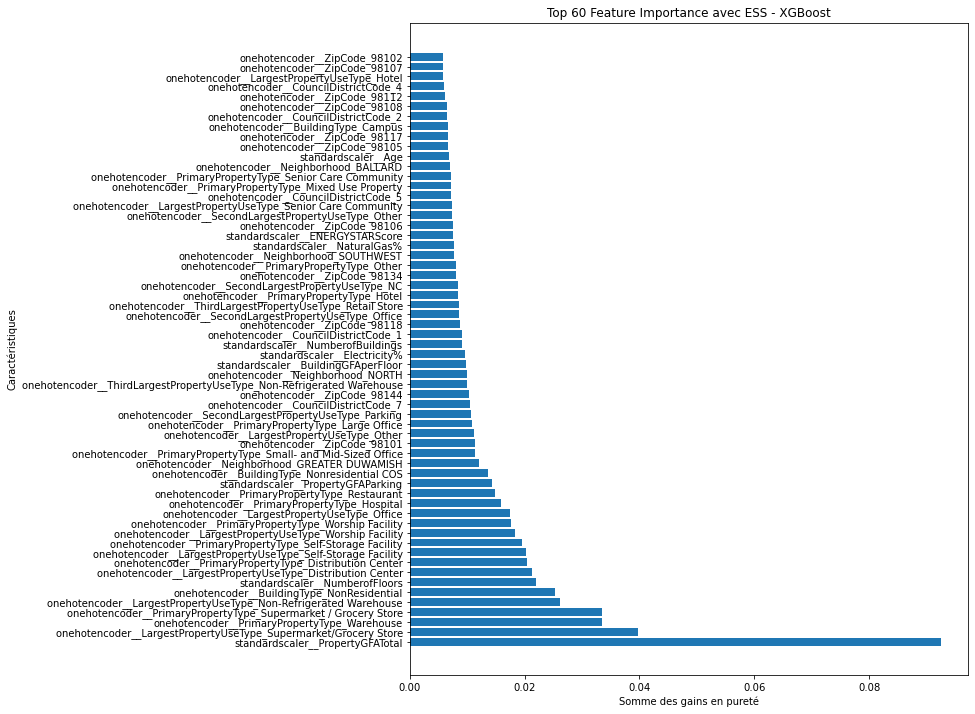

In [61]:
#A l'exception de certaines des valeurs les plus élevées, les prédictions semblent très bonnes
#Pour visualiser la feature importance on a besoin de récupérer les noms des colonnes du one-hot encoder
noms_features_oh_ess = preprocessor_oh_ess.get_feature_names_out()

#Il y en a beaucoup alors on ne va afficher que le top 60
indices_rangés_XGB_ess = np.argsort(XGB_ess.feature_importances_)[::-1]
top_features_ess = [noms_features_oh_ess[i] for i in indices_rangés_XGB_ess[:60]]
top_importances_ess = [XGB_ess.feature_importances_[i] for i in indices_rangés_XGB_ess[:60]]

#On visualise
plt.figure(figsize=(10, 12))
plt.barh(top_features_ess, top_importances_ess)
plt.xlabel('Somme des gains en pureté')
plt.ylabel('Caractéristiques')
plt.title('Top 60 Feature Importance avec ESS - XGBoost')
plt.show()

PropertyGFATotal mène toujours la danse, l'ENERGYSTARScore se situe autour de la 40ème place et semble avoir un poids moyen dans ce modèle.
# Conclusion <a class="anchor" id="conclusion"></a>
XGBoost est le meilleur modèle pour prédire la consommation énergétique des bâtiments en se basant exclusivement sur leurs données structurelles. Dans ce contexte, l'ENERGYSTARScore semble être une caractéristique d'importance moyenne en termes de prédiction, bien que le modèle entraîné avec cette variable présente des résultats légèrement meilleurs. Il faut garder en tête que l'ajout de cette feature nous a contraint à réduire la taille du jeu de données et donc, à perdre de l'information.

On se retrouve dans le notebook suivant pour un exercice similaire, concernant cette fois les émissions de CO2.